<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


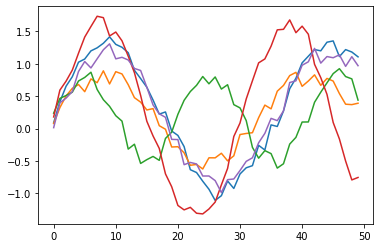

In [2]:
import numpy as np
import matplotlib.pyplot as plt

SEQ_LEN = 50

def create_time_series():
    freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
    ampl = np.random.random() + 0.5  # 0.5 to 1.5
    noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
    x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
    return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
    plt.plot(create_time_series());  # 5 series

In [3]:
def to_csv(filename, N):
    with open(filename, 'w') as ofp:
        for lineno in range(0, N):
            seq = create_time_series()
            line = ",".join(map(str, seq))
            ofp.write(line + '\n')

import os
try:
    os.makedirs("data/sines/")
except OSError:
    pass

np.random.seed(1) # makes data generation reproducible

to_csv("data/sines/train-1.csv", 1000)  # 1000 sequences
to_csv("data/sines/valid-1.csv", 250)

<h3> Read the data in a Pandas dataframe </h3>

Make sure the code works as intended.

In [4]:
TIMESERIES_COL = 'height'
N_OUTPUTS = 1  # in each sequence, 1-49 are features, and 50 is label
SEQ_LEN = None
DEFAULTS = None
N_INPUTS = 49

import pandas as pd

train = pd.read_csv("data/sines/train-1.csv", header=None)
valid = pd.read_csv("data/sines/valid-1.csv", header=None)

X = train.iloc[:,:48]
y = train.iloc[:, 49]


Xv = valid.iloc[:,:48]
yv = valid.iloc[:, 49]

<h3> Model </h3>

Linear, DNN, CNN, RNN.

2022-01-06 10:03:00.449815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 10:03:00.570582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 10:03:00.572562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 10:03:00.575149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/150
32/32 [==============================] - 2s 6ms/step - loss: 1.5268 - mse: 1.5268
Epoch 2/150
32/32 [==============================] - 0s 6ms/step - loss: 0.8055 - mse: 0.8055
Epoch 3/150
32/32 [==============================] - 0s 6ms/step - loss: 0.5263 - mse: 0.5263
Epoch 4/150
32/32 [==============================] - 0s 5ms/step - loss: 0.3733 - mse: 0.3733
Epoch 5/150
32/32 [==============================] - 0s 5ms/step - loss: 0.2775 - mse: 0.2775
Epoch 6/150
32/32 [==============================] - 0s 5ms/step - loss: 0.2157 - mse: 0.2157
Epoch 7/150
32/32 [==============================] - 0s 5ms/step - loss: 0.1762 - mse: 0.1762
Epoch 8/150
32/32 [==============================] - 0s 5ms/step - loss: 0.1487 - mse: 0.1487
Epoch 9/150
32/32 [==============================] - 0s 5ms/step - loss: 0.1305 - mse: 0.1305
Epoch 10/150
32/32 [==============================] - 0s 6ms/step - loss: 0.1188 - mse: 0.1188
Epoch 11/150
32/32 [==============================] - 0s 6m

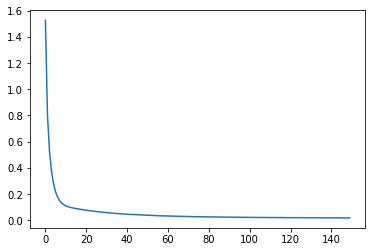

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = [48], name = TIMESERIES_COL))

# comment the line below for linear model
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss = "mse", metrics = ["mse"])
history = model.fit(X, y, epochs=150)

plt.plot(history.history['loss'])

In [6]:
model.evaluate(Xv, yv)

8/8 [==============================] - 0s 4ms/step - loss: 0.0174 - mse: 0.0174


[0.01737041026353836, 0.01737041026353836]

In [7]:
X_np = X.to_numpy()
X_np.shape

(1000, 48)

In [8]:
model_cnn = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape = [N_INPUTS - 1], name = TIMESERIES_COL),
        tf.keras.layers.Reshape(target_shape = [N_INPUTS - 1, 1]),
        tf.keras.layers.Conv1D(filters = (N_INPUTS - 1) // 2, kernel_size = 3, padding = "same", activation = tf.nn.relu),
        tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv1D(filters = (N_INPUTS -1) // 2, kernel_size = 3, padding = "same", activation = tf.nn.relu),
        tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 2),

        tf.keras.layers.Flatten(), #### THIS MAKES ALL THE DIFFERENCE
        
        tf.keras.layers.Dense(units = 3, activation = tf.nn.relu),
        tf.keras.layers.Dense(units = 1, activation = None)
    ])

model_cnn.compile(optimizer='adam', loss = "mse", metrics = ["mse"])

history = model_cnn.fit(X_np, y, epochs=150)

Epoch 1/150


2022-01-06 10:03:31.806790: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-01-06 10:03:34.365176: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


32/32 [==============================] - 4s 12ms/step - loss: 0.5823 - mse: 0.5823
Epoch 2/150
32/32 [==============================] - 0s 9ms/step - loss: 0.4713 - mse: 0.4713
Epoch 3/150
32/32 [==============================] - 0s 8ms/step - loss: 0.4065 - mse: 0.4065
Epoch 4/150
32/32 [==============================] - 0s 8ms/step - loss: 0.3579 - mse: 0.3579
Epoch 5/150
32/32 [==============================] - 0s 8ms/step - loss: 0.3196 - mse: 0.3196
Epoch 6/150
32/32 [==============================] - 0s 8ms/step - loss: 0.2925 - mse: 0.2925
Epoch 7/150
32/32 [==============================] - 0s 7ms/step - loss: 0.2708 - mse: 0.2708
Epoch 8/150
32/32 [==============================] - 0s 7ms/step - loss: 0.2514 - mse: 0.2514
Epoch 9/150
32/32 [==============================] - 0s 6ms/step - loss: 0.2340 - mse: 0.2340
Epoch 10/150
32/32 [==============================] - 0s 7ms/step - loss: 0.2185 - mse: 0.2185
Epoch 11/150
32/32 [==============================] - 0s 7ms/step - lo

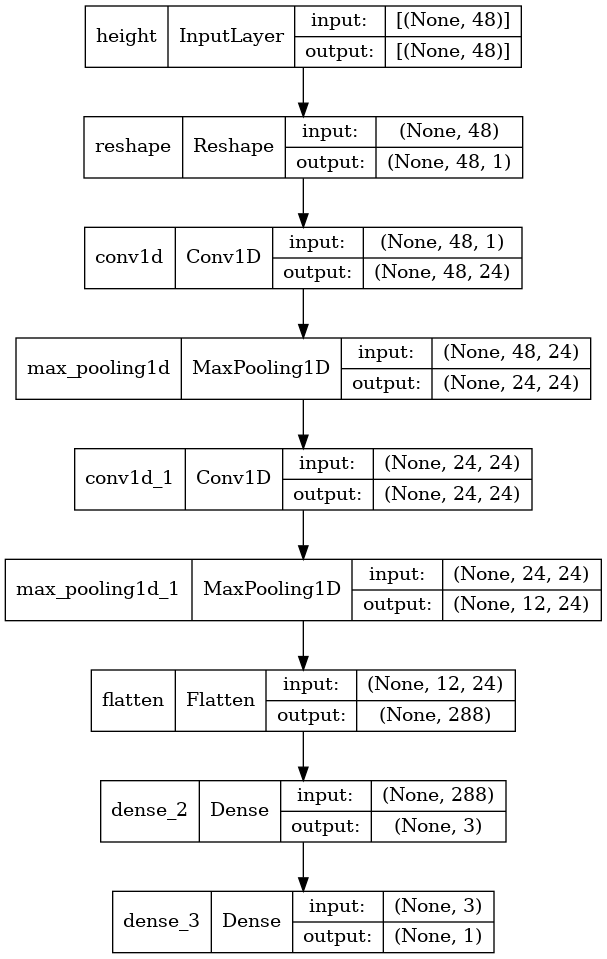

In [9]:
tf.keras.utils.plot_model(model_cnn, show_shapes=True)

In [10]:
model_cnn.evaluate(Xv, yv)

8/8 [==============================] - 0s 10ms/step - loss: 0.0132 - mse: 0.0132


[0.013239319436252117, 0.013239319436252117]

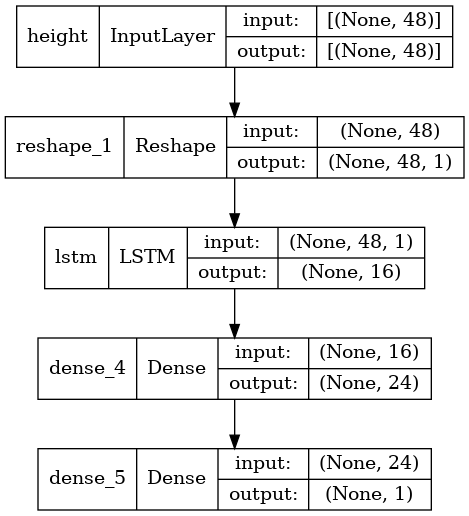

In [11]:
N_INPUTS = 48
CELL_SIZE = N_INPUTS // 3  # size of the internal state in each of the cells

model_rnn = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer(input_shape = [N_INPUTS], name = TIMESERIES_COL),

    # the reshape at the end, the 1, the 3rd dimension, represents how many features we have for each input
    tf.keras.layers.Reshape(target_shape = [N_INPUTS, 1]),

    tf.keras.layers.LSTM(units = CELL_SIZE),
    
    # one hidden layer
    tf.keras.layers.Dense(units = N_INPUTS // 2, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 1, activation = None)
])

model_rnn.compile(optimizer='adam', loss = "mse", metrics = ["mse"])

tf.keras.utils.plot_model(model_rnn, show_shapes=True)


In [12]:
history = model_rnn.fit(X_np, y, epochs=100, validation_data=(Xv, yv))
model_rnn.evaluate(Xv, yv)

Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.5185 - mse: 0.5185 - val_loss: 0.4203 - val_mse: 0.4203
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.3842 - mse: 0.3842 - val_loss: 0.2798 - val_mse: 0.2798
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.2741 - mse: 0.2741 - val_loss: 0.2109 - val_mse: 0.2109
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.2140 - mse: 0.2140 - val_loss: 0.1589 - val_mse: 0.1589
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.1576 - mse: 0.1576 - val_loss: 0.1153 - val_mse: 0.1153
Epoch 6/100
32/32 [==============================] - 0s 11ms/step - loss: 0.1088 - mse: 0.1088 - val_loss: 0.0904 - val_mse: 0.0904
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 8/100
32/32 [==============================] - 0s 13ms/step - loss: 0.

[0.012968486174941063, 0.012968486174941063]

## Results

When I ran it, these were the RMSEs that I got for different models:

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| linear | 50 | 3000 | 10 min | 0.150 |
| dnn | 50 | 3000 | 10 min | 0.101 |
| cnn | 50 | 3000 | 10 min | 0.105 |
| rnn | 50 | 3000 | 11 min | 0.100 |
| rnn2 | 50 | 3000 | 14 min |0.105 |
| rnnN | 50 | 3000 | 15 min | 0.097 |

### Analysis
You can see there is a significant improvement when switching from the linear model to non-linear models. But within the the non-linear models (DNN/CNN/RNN) performance for all is pretty similar. 

Perhaps it's because this is too simple of a problem to require advanced deep learning models. In the next lab we'll deal with a problem where an RNN is more appropriate.